In [8]:
import torch as t
t.set_default_device('mps')

import torch.nn as nn
import torch.nn.functional as f

import matplotlib.pyplot as plt

from IPython.display import clear_output
# clear_output(wait=True)


In [9]:
def sawtooth(b, p=0.2, a=0.5, th=0, ty=0):
    """
    Categorize points in 2D space into -1 or 1 categories
    based on a zigzag/sawtooth pattern.
    """

    th = t.tensor(th)

    # coordinate sampling
    c = t.rand(b, 2) * 2 - 1

    rm = t.tensor([
        [t.cos(th), -t.sin(th)],
        [t.sin(th), t.cos(th)]
        ])
    
    c = t.matmul(c, rm)

    # Split tensor into x and y coordinates
    x, y = c[:, 0], c[:, 1]

    # Create the sawtooth pattern
    saw = a * (x / p - t.floor(x / p + 0.5))

    # Categorize points: -1 if y coordinate is less than sawtooth pattern, else 1
    z = t.where(y+ty < saw, -t.ones_like(y), t.ones_like(y)).unsqueeze(1)

    # reverse the transform to get the original coordinates
    c = t.matmul(c, rm.t())

    return c, z



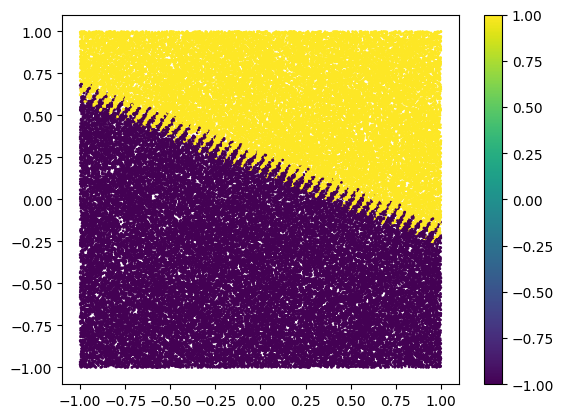

In [146]:
b = 2**16
p = 0.05
a = 0.15
th = -0.4
ty = -.2
xy, z = sawtooth(b, p=p, a=a, th=th, ty=ty)

px, py, pz = xy[:, 0].cpu().numpy(), xy[:,1].cpu().numpy(), z.cpu().numpy()

# create a scatter plot
fig = plt.figure()
ax = fig.add_subplot()
sc = ax.scatter(px, py, c=pz, s=1)

# Add a color bar
plt.colorbar(sc)

plt.show()

In [147]:
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.GELU(),
    nn.Linear(128, 128),
    nn.GELU(),
    nn.Linear(128, 128),
    nn.GELU(),
    nn.Linear(128, 1)
)

# define the loss function
loss_fn = nn.MSELoss()

# define the optimizer
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)


In [148]:
for frame in range(50):
    for epoch in range(1000):
        # forward pass
        y_pred = model(xy)

        # compute loss
        loss = loss_fn(y_pred, z)

        # zero gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # print loss
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss {loss.item()}")

    with t.no_grad():
        nxy, nz = sawtooth(50000, p=p, a=a, th=th, ty=ty)
        dnz = nz - model(nxy).detach()
        npx, npy = nxy[:, 0].cpu().numpy(), nxy[:,1].cpu().numpy()
        mz = model(nxy).detach().cpu().numpy()
        dnz = dnz.cpu().numpy()
        oz = nz.cpu().numpy()


        fig, axs = plt.subplots(3, 2, figsize=(10, 12))

        # test output
        testout = axs[0, 0].scatter(npx, npy, c=mz, s=1, cmap='gray')
        axs[0, 0].set_title('Test Output')
        fig.colorbar(testout, ax=axs[0, 0])

        # test target
        testtarget = axs[1, 0].scatter(npx, npy, c=oz, s=1, cmap='gray')
        axs[1, 0].set_title('Test Target')
        fig.colorbar(testtarget, ax=axs[1, 0])

        # test error
        testerr = axs[2, 0].scatter(npx, npy, c=dnz, s=1, cmap='bwr')
        axs[2, 0].set_title('Test Error')
        fig.colorbar(testerr, ax=axs[2, 0])

        # train output
        predz = model(xy).detach().cpu().numpy()
        predz = predz.clip(-1, 1)
        trainout = axs[0, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=predz, s=1, cmap='gray')
        axs[0, 1].set_title('Train Output')
        fig.colorbar(trainout, ax=axs[0, 1])

        # train target
        traintarget = axs[1, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=z.cpu().numpy(), s=1, cmap='gray')
        axs[1, 1].set_title('Train Target')
        fig.colorbar(traintarget, ax=axs[1, 1])

        # train error
        dz = z - model(xy).detach()
        dz = dz.cpu().numpy()

        trainerr = axs[2, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=dz, s=1, cmap='bwr')
        axs[2, 1].set_title('Train error')
        fig.colorbar(trainerr, ax=axs[2, 1])

        # save the plot as an image at downscaled resolution
        plt.savefig(f'giffto/interleaved_{frame}.png', dpi=50, bbox_inches='tight', pad_inches=0)
        plt.close()



Epoch 0, Loss 0.9862065315246582
Epoch 100, Loss 0.13915833830833435
Epoch 200, Loss 0.06722863763570786
Epoch 300, Loss 0.05724944919347763
Epoch 400, Loss 0.05532723665237427
Epoch 500, Loss 0.05482470244169235
Epoch 600, Loss 0.05466292053461075
Epoch 700, Loss 0.05460308492183685
Epoch 800, Loss 0.05457603931427002
Epoch 900, Loss 0.05456823483109474
Epoch 0, Loss 0.05454741418361664
Epoch 100, Loss 0.05471077561378479
Epoch 200, Loss 0.05453009903430939
Epoch 300, Loss 0.05452323704957962
Epoch 400, Loss 0.0545213557779789
Epoch 500, Loss 0.054512713104486465
Epoch 600, Loss 0.05450800433754921
Epoch 700, Loss 0.05450553447008133
Epoch 800, Loss 0.054500121623277664
Epoch 900, Loss 0.054496314376592636
Epoch 0, Loss 0.05449333414435387
Epoch 100, Loss 0.05448991805315018
Epoch 200, Loss 0.05448674038052559
Epoch 300, Loss 0.05448486655950546
Epoch 400, Loss 0.05448170751333237
Epoch 500, Loss 0.05447915941476822
Epoch 600, Loss 0.05447734519839287
Epoch 700, Loss 0.054476171731948

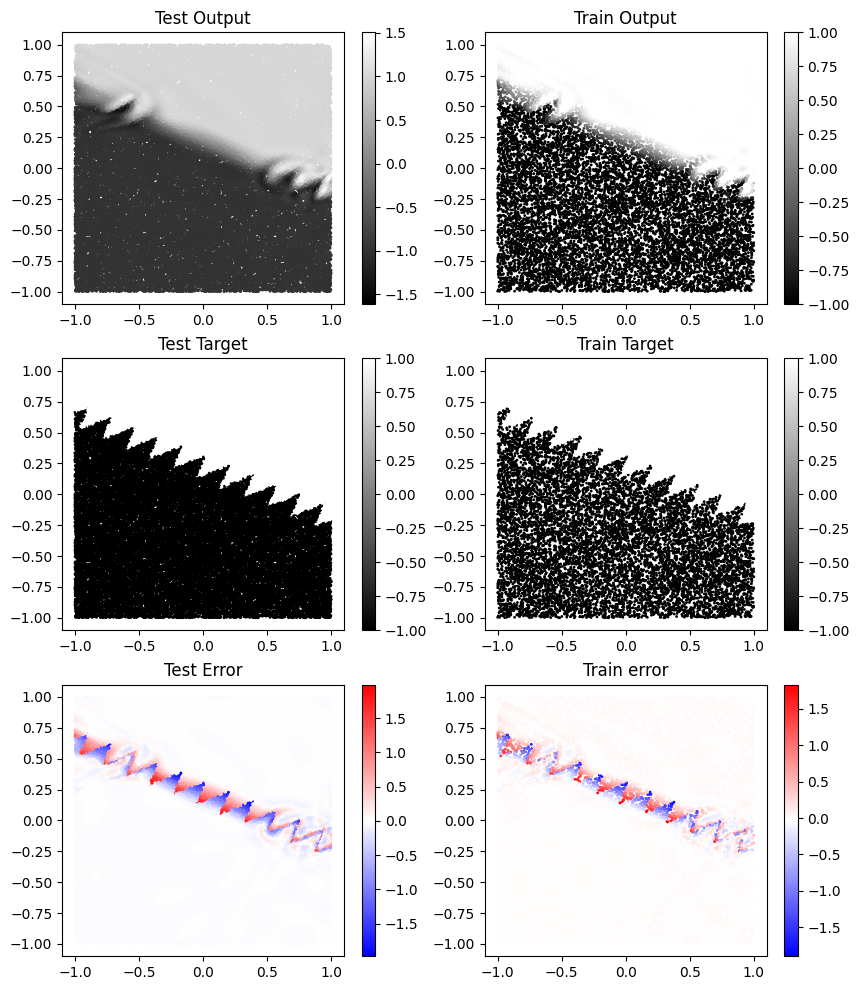

In [133]:
nxy, nz = sawtooth(50000, p=p, a=a, th=th, ty=ty)
dnz = nz - model(nxy).detach()
npx, npy = nxy[:, 0].cpu().numpy(), nxy[:,1].cpu().numpy()
mz = model(nxy).detach().cpu().numpy()
dnz = dnz.cpu().numpy()
oz = nz.cpu().numpy()


fig, axs = plt.subplots(3, 2, figsize=(10, 12))

# test output
testout = axs[0, 0].scatter(npx, npy, c=mz, s=1, cmap='gray')
axs[0, 0].set_title('Test Output')
fig.colorbar(testout, ax=axs[0, 0])

# test target
testtarget = axs[1, 0].scatter(npx, npy, c=oz, s=1, cmap='gray')
axs[1, 0].set_title('Test Target')
fig.colorbar(testtarget, ax=axs[1, 0])

# test error
testerr = axs[2, 0].scatter(npx, npy, c=dnz, s=1, cmap='bwr')
axs[2, 0].set_title('Test Error')
fig.colorbar(testerr, ax=axs[2, 0])

# train output
predz = model(xy).detach().cpu().numpy()
predz = predz.clip(-1, 1)
trainout = axs[0, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=predz, s=1, cmap='gray')
axs[0, 1].set_title('Train Output')
fig.colorbar(trainout, ax=axs[0, 1])

# train target
traintarget = axs[1, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=z.cpu().numpy(), s=1, cmap='gray')
axs[1, 1].set_title('Train Target')
fig.colorbar(traintarget, ax=axs[1, 1])

# train error
dz = z - model(xy).detach()
dz = dz.cpu().numpy()

trainerr = axs[2, 1].scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy(), c=dz, s=1, cmap='bwr')
axs[2, 1].set_title('Train error')
fig.colorbar(trainerr, ax=axs[2, 1])

plt.show()